THE INDEXING PHASE :

In [ ]:
# Step1: Importing dependencies
import os
from langchain.schema import Document
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_community.embeddings import HuggingFaceEmbeddings
from langchain_community.vectorstores import Chroma
import torch

# Step2: Configuration parameters
MD_FILES_DIRECTORY = "data/extracted_docling.md"
PERSIST_DIRECTORY = "data_naive_rag"
COLLECTION_NAME = "naive_rag_leaflets"

EMBEDDING_MODEL_NAME = "sentence-transformers/all-MiniLM-L6-v2"
EMBEDDING_DEVICE = "cpu"  

CHUNK_SIZE = 512
CHUNK_OVERLAP = 20

# Step3: Loading .md files into LangChain Document objects
raw_documents = []
for filename in os.listdir(MD_FILES_DIRECTORY):
    if filename.endswith(".md"):
        filepath = os.path.join(MD_FILES_DIRECTORY, filename)
        try:
            with open(filepath, "r", encoding="utf-8") as f:
                content = f.read()
            doc = Document(page_content=content, metadata={"source_file": filename})
            raw_documents.append(doc)
        except Exception as e:
            print(f"Error loading {filename}: {e}")

# Step4: Recursive chunking
text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=CHUNK_SIZE,
    chunk_overlap=CHUNK_OVERLAP,
    length_function=len,
    is_separator_regex=False
)
chunks = text_splitter.split_documents(raw_documents)

# Step5:Embeddings 
try:
    embedding_model = HuggingFaceEmbeddings(
        model_name=EMBEDDING_MODEL_NAME,
        model_kwargs={'device': EMBEDDING_DEVICE}
    )
except Exception as e:
    print(f"Error initializing embedding model: {e}")
    exit()

# Task 6: Store chunks in ChromaDB
os.makedirs(PERSIST_DIRECTORY, exist_ok=True)
try:
    vectorstore = Chroma.from_documents(
        documents=chunks,
        embedding=embedding_model,
        persist_directory=PERSIST_DIRECTORY,
        collection_name=COLLECTION_NAME
    )
except Exception as e:
    print(f"Error storing chunks in ChromaDB: {e}")
    exit()


THE RETRIEVAL AND GENERATION PHASES :

In [ ]:
## EXAMPLE 1 of the Naive RAG system performance :

# Step 1: Importing necessary libraries

from langchain_community.embeddings import HuggingFaceEmbeddings
from langchain_community.vectorstores import Chroma
from langchain.chains import RetrievalQA
from langchain_core.prompts import PromptTemplate
from langchain_mistralai.chat_models import ChatMistralAI
from langchain_core.prompts import ChatPromptTemplate


# Step 2 : configuration 
CHROMA_DB_DIRECTORY = "data_naive_rag"
COLLECTION_NAME = "naive_rag_leaflets"
EMBEDDING_MODEL_NAME = "sentence-transformers/all-MiniLM-L6-v2"
EMBEDDING_DEVICE = "cpu"
MISTRAL_API_KEY = 'YOUR_API_KEY_HERE'
K_DOCUMENTS = 6

# Step 3: Initializing the LLM model
llm = None
try:
    print("Initializing MistralAI LLM...")
    llm = ChatMistralAI(mistral_api_key=MISTRAL_API_KEY)
    print("MistralAI LLM initialized successfully.")
except Exception as e:
    print(f"ERROR: Could not initialize MistralAI LLM: {e}")

    exit()

# Step 4: Initializing Embedding Model and Connecting to ChromaDB 
embedding_model = None
vectorstore = None
try:
    print(f"Loading embedding model: {EMBEDDING_MODEL_NAME} on {EMBEDDING_DEVICE}...")
    embedding_model = HuggingFaceEmbeddings(
        model_name=EMBEDDING_MODEL_NAME,
        model_kwargs={'device': EMBEDDING_DEVICE}
    )
    print("Embedding model loaded.")

    print(f"Connecting to ChromaDB collection '{COLLECTION_NAME}' at: {CHROMA_DB_DIRECTORY}...")
    if not os.path.exists(CHROMA_DB_DIRECTORY):
        print(f"ERROR: ChromaDB directory not found: {CHROMA_DB_DIRECTORY}")

        exit()
    vectorstore = Chroma(
        persist_directory=CHROMA_DB_DIRECTORY,
        embedding_function=embedding_model,
        collection_name=COLLECTION_NAME
    )
    print("ChromaDB connected.")

except Exception as e:
    print(f"ERROR: Could not load embedding model or connect to ChromaDB: {e}")
   
    exit()

# Step 5: Defining the Prompt Template -

RAG_prompt = ChatPromptTemplate.from_template("""
## DIRECTIVES ABSOLUTES (NON-NÉGOCIABLES)
1. **IDENTIFIE le nom EXACT du médicament** mentionné dans le CONTEXTE fourni. N'utilise que CE nom.
2. **Réponds UNIQUEMENT** si la question porte sur le médicament IDENTIFIÉ dans le contexte ET si l'information demandée est présente dans le contexte.
3. **Interdictions formelles** : Aucune information non présente dans le contexte. Aucun autre nom de médicament.

### PROTOCOLE DE VÉRIFICATION (POUR VOTRE RAISONNEMENT INTERNE SEULEMENT - NE PAS AFFICHER CE PROTOCOLE DANS LA RÉPONSE)
1. Quel est le nom du médicament dans le CONTEXTE ?
2. La QUESTION porte-t-elle sur CE médicament ?
3. L'information demandée dans la QUESTION est-elle dans le CONTEXTE ?

### FORMAT DE RÉPONSE CONTRAINT
[VÉRIFICATION INITIALE]
"Après analyse complète de la notice officielle de [RÉPONSE UNIQUE: LE NOM EXACT DU MÉDICAMENT IDENTIFIÉ DANS LE CONTEXTE] fournie :"

[PRÉSENTATION DES PREUVRES]
"**Source textuelle directe** (extrait fidèle) :
« [Citation EXACTE du contexte pertinente pour la réponse] »"

[INTERPRÉTATION CADRÉE]
"Ceci signifie que : [Explication courte basée uniquement sur la citation]"

[LIMITES]
"Information disponible : [Oui/Non/Partielle]
Couverture contextuelle : [Complete/Partielle/Section X seulement]"

### RÉPONSE PAR DÉFAUT (SI LES CONDITIONS NE SONT PAS REMPLIES)
"Impossible de répondre :
- [Raison spécifique : médicament non trouvé dans le contexte / information absente dans le contexte]
- Consulter un pharmacien pour les questions hors notice"

### CONTEXTE FOURNI
{context}

### QUESTION
{question}

"""
)

print("Prompt template defined.")

# Step 6: Creating the Retriever 
retriever = vectorstore.as_retriever(search_kwargs={"k": K_DOCUMENTS})
print(f"Retriever created (k={K_DOCUMENTS}).")

# Step 7: Creating the RAG Chain (RetrievalQA) 
qa_chain = None
try:
    print("Initializing Naive RAG chain...")
    qa_chain = RetrievalQA.from_chain_type(
        llm=llm,
        chain_type="stuff",
        retriever=retriever,
        return_source_documents=True,
        chain_type_kwargs={"prompt": RAG_prompt},
        input_key="question"
    )
    print("Naive RAG chain initialized successfully.")
except Exception as e:
    print(f"ERROR: Could not initialize RAG chain: {e}")
   
    exit()

# Step 8: Trying a Sample Query for qualitative evaluation
if qa_chain:
    sample_query = "quelle est la dose recommende par jour de curacne 5mg caps?"
    print(f"\nRunning sample query: '{sample_query}'")

    try:
        response = qa_chain.invoke({"question": sample_query})

        # --- Display Results ---
        print("\n--- Answer ---")
        print(response.get('result', 'No answer generated.'))

        print("\n--- Source Documents ---")
        if response.get("source_documents"):
            for i, doc in enumerate(response["source_documents"]):
                print(f"Doc {i+1}:")
                print(f"  Source File: {doc.metadata.get('source_file', 'N/A')}")
                print(f"  Content Snippet: {doc.page_content[:200]}...")
                print("-" * 30)
        else:
            print("No source documents returned.")

    except Exception as e:
        print(f"Error during query execution: {e}")
else:
    print("\nNaive RAG chain not initialized.")

# Step 9 : Displaying full retrieved chunks for analysis
retrieved_docs = response.get("source_documents", [])
print("\n--- Retrieved Chunks (Full Text) ---")
for i, doc in enumerate(retrieved_docs):
    print(f"\n[Chunk {i+1}] — File: {doc.metadata.get('source_file', 'Unknown')}")
    print(f"Chunk Index: {doc.metadata.get('chunk_index', 'Unknown')}")
    print("----------- Content -----------")
    print(doc.page_content.strip())
    print("-" * 80)



Initializing MistralAI LLM...
MistralAI LLM initialized successfully.
Loading embedding model: sentence-transformers/all-MiniLM-L6-v2 on cpu...


C:\Users\ALIENWARE\AppData\Local\Temp\ipykernel_896\342108920.py:38: LangChainDeprecationWarning: The class `HuggingFaceEmbeddings` was deprecated in LangChain 0.2.2 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-huggingface package and should be used instead. To use it run `pip install -U :class:`~langchain-huggingface` and import as `from :class:`~langchain_huggingface import HuggingFaceEmbeddings``.
  embedding_model = HuggingFaceEmbeddings(


Embedding model loaded.
Connecting to ChromaDB collection 'naive_rag_leaflets' at: data_naive_rag...


C:\Users\ALIENWARE\AppData\Local\Temp\ipykernel_896\342108920.py:49: LangChainDeprecationWarning: The class `Chroma` was deprecated in LangChain 0.2.9 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-chroma package and should be used instead. To use it run `pip install -U :class:`~langchain-chroma` and import as `from :class:`~langchain_chroma import Chroma``.
  vectorstore = Chroma(


ChromaDB connected.
Prompt template defined.
Retriever created (k=6).
Initializing Naive RAG chain...
Naive RAG chain initialized successfully.

Running sample query: 'quelle est la dose recommende par jour de curacne 5mg caps?'

--- Answer ---
[VÉRIFICATION INITIALE]
"Après analyse complète de la notice officielle de CURACNE 5 mg, capsule molle Isotrétinoïne fournie :"

[PRÉSENTATION DES PREUVES]
"**Source textuelle directe** (extrait fidèle) :
« Posologie : Prenez toujours CURACNE en suivant à la lettre les recommandations de votre médecin. En cas de doute, consultez votre médecin ou votre pharmacien.

Le traitement par CURACNE doit être prescrit et surveillé par un médecin ayant une bonne expérience dans l'utilisation et le suivi des rétinoïdes dans le traitement des acnés sévères.

CURACNE n'est pas indiqué pour traiter les acnés survenant avant la puberté et n'est pas recommandé avant l'âge de 12 ans. »"

[INTERPRÉTATION CADRÉE]
"Ceci signifie que la dose recommandée par jour de C

In [ ]:
## EXAMPLE 2 of the Naive RAG performance:

# Step 1: Importing necessary libraries
import os
from langchain_community.embeddings import HuggingFaceEmbeddings
from langchain_community.vectorstores import Chroma
from langchain.chains import RetrievalQA
from langchain_core.prompts import PromptTemplate
from langchain_mistralai.chat_models import ChatMistralAI
from langchain_core.prompts import ChatPromptTemplate


# Step 2 : configuration 
CHROMA_DB_DIRECTORY = "data_naive_rag"
COLLECTION_NAME = "naive_rag_leaflets"
EMBEDDING_MODEL_NAME = "sentence-transformers/all-MiniLM-L6-v2"
EMBEDDING_DEVICE = "cuda"
MISTRAL_API_KEY = 'YOUR_API_KEY_HERE'
K_DOCUMENTS = 6

# Step 3: Initializing the LLM model
llm = None
try:
    print("Initializing MistralAI LLM...")
    llm = ChatMistralAI(mistral_api_key=MISTRAL_API_KEY)
    print("MistralAI LLM initialized successfully.")
except Exception as e:
    print(f"ERROR: Could not initialize MistralAI LLM: {e}")

    exit()

# Step 4: Initializing Embedding Model and Connecting to ChromaDB 
embedding_model = None
vectorstore = None
try:
    print(f"Loading embedding model: {EMBEDDING_MODEL_NAME} on {EMBEDDING_DEVICE}...")
    embedding_model = HuggingFaceEmbeddings(
        model_name=EMBEDDING_MODEL_NAME,
        model_kwargs={'device': EMBEDDING_DEVICE}
    )
    print("Embedding model loaded.")

    print(f"Connecting to ChromaDB collection '{COLLECTION_NAME}' at: {CHROMA_DB_DIRECTORY}...")
    if not os.path.exists(CHROMA_DB_DIRECTORY):
        print(f"ERROR: ChromaDB directory not found: {CHROMA_DB_DIRECTORY}")

        exit()
    vectorstore = Chroma(
        persist_directory=CHROMA_DB_DIRECTORY,
        embedding_function=embedding_model,
        collection_name=COLLECTION_NAME
    )
    print("ChromaDB connected.")

except Exception as e:
    print(f"ERROR: Could not load embedding model or connect to ChromaDB: {e}")
   
    exit()

# Step 5: Defining the Prompt Template -

RAG_prompt = ChatPromptTemplate.from_template("""
## DIRECTIVES ABSOLUTES (NON-NÉGOCIABLES)
1. **IDENTIFIE le nom EXACT du médicament** mentionné dans le CONTEXTE fourni. N'utilise que CE nom.
2. **Réponds UNIQUEMENT** si la question porte sur le médicament IDENTIFIÉ dans le contexte ET si l'information demandée est présente dans le contexte.
3. **Interdictions formelles** : Aucune information non présente dans le contexte. Aucun autre nom de médicament.

### PROTOCOLE DE VÉRIFICATION (POUR VOTRE RAISONNEMENT INTERNE SEULEMENT - NE PAS AFFICHER CE PROTOCOLE DANS LA RÉPONSE)
1. Quel est le nom du médicament dans le CONTEXTE ?
2. La QUESTION porte-t-elle sur CE médicament ?
3. L'information demandée dans la QUESTION est-elle dans le CONTEXTE ?

### FORMAT DE RÉPONSE CONTRAINT
[VÉRIFICATION INITIALE]
"Après analyse complète de la notice officielle de [RÉPONSE UNIQUE: LE NOM EXACT DU MÉDICAMENT IDENTIFIÉ DANS LE CONTEXTE] fournie :"

[PRÉSENTATION DES PREUVRES]
"**Source textuelle directe** (extrait fidèle) :
« [Citation EXACTE du contexte pertinente pour la réponse] »"

[INTERPRÉTATION CADRÉE]
"Ceci signifie que : [Explication courte basée uniquement sur la citation]"

[LIMITES]
"Information disponible : [Oui/Non/Partielle]
Couverture contextuelle : [Complete/Partielle/Section X seulement]"

### RÉPONSE PAR DÉFAUT (SI LES CONDITIONS NE SONT PAS REMPLIES)
"Impossible de répondre :
- [Raison spécifique : médicament non trouvé dans le contexte / information absente dans le contexte]
- Consulter un pharmacien pour les questions hors notice"

### CONTEXTE FOURNI
{context}

### QUESTION
{question}

"""
)

print("Prompt template defined.")

# Step 6: Creating the Retriever 
retriever = vectorstore.as_retriever(search_kwargs={"k": K_DOCUMENTS})
print(f"Retriever created (k={K_DOCUMENTS}).")

# Step 7: Creating the RAG Chain (RetrievalQA) 
qa_chain = None
try:
    print("Initializing Naive RAG chain...")
    qa_chain = RetrievalQA.from_chain_type(
        llm=llm,
        chain_type="stuff",
        retriever=retriever,
        return_source_documents=True,
        chain_type_kwargs={"prompt": RAG_prompt},
        input_key="question"
    )
    print("Naive RAG chain initialized successfully.")
except Exception as e:
    print(f"ERROR: Could not initialize RAG chain: {e}")
   
    exit()

# Step 8: Trying a Sample Query for qualitative evaluation
if qa_chain:
    sample_query = "Quels sont les cas à ne pas utiliser DEXOREN 0.25mg comp?"
    print(f"\nRunning sample query: '{sample_query}'")
    try:
        response = qa_chain.invoke({"question": sample_query})

        # --- Display Results ---
        print("\n--- Answer ---")
        print(response.get('result', 'No answer generated.'))

        print("\n--- Source Documents ---")
        if response.get("source_documents"):
            for i, doc in enumerate(response["source_documents"]):
                print(f"Doc {i+1}:")
                print(f"  Source File: {doc.metadata.get('source_file', 'N/A')}")
                print(f"  Content Snippet: {doc.page_content[:200]}...")
                print("-" * 30)
        else:
            print("No source documents returned.")

    except Exception as e:
        print(f"Error during query execution: {e}")
else:
    print("\nNaive RAG chain not initialized.")

# Step 9 : Displaying full retrieved chunks for analysis
retrieved_docs = response.get("source_documents", [])
print("\n--- Retrieved Chunks (Full Text) ---")
for i, doc in enumerate(retrieved_docs):
    print(f"\n[Chunk {i+1}] — File: {doc.metadata.get('source_file', 'Unknown')}")
    print(f"Chunk Index: {doc.metadata.get('chunk_index', 'Unknown')}")
    print("----------- Content -----------")
    print(doc.page_content.strip())
    print("-" * 80)


Initializing MistralAI LLM...
MistralAI LLM initialized successfully.
Loading embedding model: sentence-transformers/all-MiniLM-L6-v2 on cuda...
Embedding model loaded.
Connecting to ChromaDB collection 'naive_rag_leaflets' at: data_naive_rag...
ChromaDB connected.
Prompt template defined.
Retriever created (k=6).
Initializing Naive RAG chain...
Naive RAG chain initialized successfully.

Running sample query: 'Quels sont les cas à ne pas utiliser DEXOREN 0.25mg comp?'

--- Answer ---
[VÉRIFICATION INITIALE]
"Après analyse complète de la notice officielle de HEMI-DAONIL 2,5 mg, comprimé sécable fournie :"

[PRÉSENTATION DES PREUVES]
"**Source textuelle directe** (extrait fidèle) :
« Ce médicament vous a été personnellement prescrit. Ne le donnez à personne d'autre. Vous risqueriez de lui causer du tort. même si elle présente les mêmes symptômes que vous. »"

[INTERPRÉTATION CADRÉE]
"Ceci signifie que : HEMI-DAONIL 2,5 mg, comprimé sécable ne doit être utilisé que sur prescription médica

PREPARING THE EVALUATION DATASET

In [ ]:
"""
This script runs the Naive RAG pipeline on a predefined list of test cases
to generate evaluation data for the RAGAS framework.

Each test case must contain:
- "question_id": unique identifier (a string)
- "question": user question (a string)
- "ground_truth": list of expected answers (a list of strings)


- The output is a CSV file named `ragas_input_data_naive_rag.csv` containing:
    - question_id, question, answer (LLM), contexts (retrieved text), ground_truth (reference answers obtained from the Algerian leaflets)
"""


import pandas as pd

## Import the test_cases which contain the questions to be asked to the system :

from test_cases import test_cases


# Configuration
CHROMA_DB_DIRECTORY = "data_naive_rag"
COLLECTION_NAME = "naive_rag_leaflets"
EMBEDDING_MODEL_NAME = "sentence-transformers/all-MiniLM-L6-v2"
EMBEDDING_DEVICE = "cpu"
MISTRAL_API_KEY = "YOUR_API_KEY_HERE"
K_DOCUMENTS = 6

# Loading the LLM
try:
    llm = ChatMistralAI(mistral_api_key=MISTRAL_API_KEY)
except Exception as e:
    print(f"Error initializing LLM: {e}")
    exit()

# Loading embeddings and connect to Chroma
try:
    embedding_model = HuggingFaceEmbeddings(
        model_name=EMBEDDING_MODEL_NAME,
        model_kwargs={'device': EMBEDDING_DEVICE}
    )
    if not os.path.exists(CHROMA_DB_DIRECTORY):
        raise FileNotFoundError(f"ChromaDB directory not found: {CHROMA_DB_DIRECTORY}")

    vectorstore = Chroma(
        persist_directory=CHROMA_DB_DIRECTORY,
        embedding_function=embedding_model,
        collection_name=COLLECTION_NAME
    )
except Exception as e:
    print(f"Error loading embedding model or connecting to ChromaDB: {e}")
    exit()

# Defining prompt
RAG_prompt = ChatPromptTemplate.from_template("""
## DIRECTIVES ABSOLUTES (NON-NÉGOCIABLES)
1. **IDENTIFIE le nom EXACT du médicament** mentionné dans le CONTEXTE fourni. N'utilise que CE nom.
2. **Réponds UNIQUEMENT** si la question porte sur le médicament IDENTIFIÉ dans le contexte ET si l'information demandée est présente dans le contexte.
3. **Interdictions formelles** : Aucune information non présente dans le contexte. Aucun autre nom de médicament.

### PROTOCOLE DE VÉRIFICATION (POUR VOTRE RAISONNEMENT INTERNE SEULEMENT - NE PAS AFFICHER CE PROTOCOLE DANS LA RÉPONSE)
1. Quel est le nom du médicament dans le CONTEXTE ?
2. La QUESTION porte-t-elle sur CE médicament ?
3. L'information demandée dans la QUESTION est-elle dans le CONTEXTE ?

### FORMAT DE RÉPONSE CONTRAINT
[VÉRIFICATION INITIALE]
"Après analyse complète de la notice officielle de [RÉPONSE UNIQUE: LE NOM EXACT DU MÉDICAMENT IDENTIFIÉ DANS LE CONTEXTE] fournie :"

[PRÉSENTATION DES PREUVRES]
"**Source textuelle directe** (extrait fidèle) :
« [Citation EXACTE du contexte pertinente pour la réponse] »"

[INTERPRÉTATION CADRÉE]
"Ceci signifie que : [Explication courte basée uniquement sur la citation]"

[LIMITES]
"Information disponible : [Oui/Non/Partielle]
Couverture contextuelle : [Complete/Partielle/Section X seulement]"

### RÉPONSE PAR DÉFAUT (SI LES CONDITIONS NE SONT PAS REMPLIES)
"Impossible de répondre :
- [Raison spécifique : médicament non trouvé dans le contexte / information absente dans le contexte]
- Consulter un pharmacien pour les questions hors notice"

### CONTEXTE FOURNI
{context}

### QUESTION
{question}
""")

# Initializing retriever and RAG chain
retriever = vectorstore.as_retriever(search_kwargs={"k": K_DOCUMENTS})
qa_chain = RetrievalQA.from_chain_type(
    llm=llm,
    chain_type="stuff",
    retriever=retriever,
    return_source_documents=True,
    chain_type_kwargs={"prompt": RAG_prompt},
    input_key="question"
)


# Running the loop and collecting results
ragas_data = []
for test_case in test_cases:
    qid = test_case["question_id"]
    query = test_case["question"]
    references = test_case["ground_truth"]

    try:
        response = qa_chain.invoke({"question": query})
        answer = response.get("result", "No answer generated.")
        contexts = [doc.page_content for doc in response.get("source_documents", [])]

        ragas_data.append({
            "question_id": qid,
            "question": query,
            "answer": answer,
            "contexts": contexts,
            "ground_truth": references
        })

    except Exception as e:
        print(f"Error processing {qid}: {e}")

# Saveing to a CSV file
if ragas_data:
    df = pd.DataFrame(ragas_data)
    df.to_csv("ragas_input_data_naive_rag.csv", index=False, encoding='utf-8-sig')
    print("Saved RAGAS input data to ragas_input_data_naive_rag.csv")
else:
    print("No data collected.")




In [ ]:
"""
    This function Extracts the content from the [INTERPRÉTATION CADRÉE] section of the LLM response
     and if a refusal message or malformed structure is detected, returns a fallback message.
"""


def extract_interpretation(llm_response_text):
    llm_response_text = llm_response_text.strip()
    refusal_start_marker = "[IMPOSSIBLE DE RÉPONDRE]"

    if llm_response_text.startswith(refusal_start_marker):
        return "Impossible de répondre. Veuillez consulter un professionnel de santé pour l'information nécessaire."

    start_marker = "[INTERPRÉTATION CADRÉE]"
    end_markers = [
        "[LIMITES]",
        "### RÉPONSE PAR DÉFAUT",
        "### CONTEXTE FOURNI",
        "[VÉRIFICATION INITIALE]",
        "[PRÉSENTATION DES PREUVRES]",
        refusal_start_marker
    ]

    start_index = llm_response_text.find(start_marker)
    if start_index == -1:
        return "Information non trouvée dans le contexte fourni. Veuillez consulter un professionnel de santé."

    content_start_index = start_index + len(start_marker)
    first_newline = llm_response_text.find('\n', content_start_index)
    if first_newline != -1:
        content_start_index = first_newline + 1

    end_index = -1
    for marker in end_markers:
        idx = llm_response_text.find(marker, content_start_index)
        if idx != -1 and (end_index == -1 or idx < end_index):
            end_index = idx

    if end_index != -1:
        interpretation = llm_response_text[content_start_index:end_index].strip()
    else:
        interpretation = llm_response_text[content_start_index:].strip()

    prefixes = ["Ceci signifie que :", "Réponse :"]
    for prefix in prefixes:
        if interpretation.startswith(prefix):
            interpretation = interpretation[len(prefix):].strip()
            break

    if interpretation.startswith('"') and interpretation.endswith('"'):
        interpretation = interpretation[1:-1].strip()
    elif interpretation.startswith('"'):
        interpretation = interpretation[1:].strip()
    elif interpretation.endswith('"'):
        interpretation = interpretation[:-1].strip()

    if not interpretation:
        return "Information non trouvée dans le contexte fourni. Veuillez consulter un professionnel de santé."

    return interpretation


In [ ]:
"""
This script loads the naive RAG evaluation CSV,
extracts only the [INTERPRÉTATION CADRÉE] section from each answer,
and saves a cleaned version for RAGAS evaluation.

The 'ragas_dataset_naive_rag.csv' has four columns: question_id, question, answer, contexts, ground_truth
"""

input_csv_filename = "ragas_input_data_naive_rag.csv" 
output_csv_filename = "ragas_dataset_naive_rag.csv" 

try:
    df = pd.read_csv(input_csv_filename)
    print(f"Successfully loaded '{input_csv_filename}' with {len(df)} rows.")

    if 'answer' not in df.columns:
        raise ValueError("CSV file must contain an 'answer' column.")

    print(f"\nParsing 'answer' column to extract ONLY [INTERPRÉTATION CADRÉE] content...")
    

    df['answer'] = df['answer'].apply(extract_interpretation)
    print("Finished parsing 'answer' column.")

    
    required_ragas_columns = ['question_id', 'question', 'answer', 'contexts', 'ground_truth']
    df_for_ragas = df[required_ragas_columns]
    
    df_for_ragas.to_csv(output_csv_filename, index=False, encoding='utf-8-sig')
    print(f"\nProcessed data with ONLY [INTERPRÉTATION CADRÉE] as 'answer' saved to: {output_csv_filename}")

    print("\nFirst 10 rows of the final RAGAS dataset (answer column):")
    pd.set_option('display.max_colwidth', None) 
    for index, row in df_for_ragas.head(10).iterrows():
        print(f"--- Q_ID: {row['question_id']} ---")
        print(f"Parsed Answer: {row['answer']}")
        print("-" * 20)
    
    
    empty_answers_count = (df_for_ragas['answer'] == '').sum()
    print(f"\nNumber of rows with an empty 'answer' after parsing: {empty_answers_count} out of {len(df_for_ragas)}")


except FileNotFoundError:
    print(f"CRITICAL ERROR: Input CSV file '{input_csv_filename}' not found.")
except ValueError as ve:
    print(f"ValueError: {ve}")
except Exception as e:
    print(f"An unexpected error:{e}")

THE RAGAS EVALUATION PROCESS :

In [ ]:
from datasets import Dataset
import ast 


# Importing the RAGAS components
from ragas import evaluate
from ragas.metrics import (
    faithfulness,
    answer_relevancy,
    context_recall,
    context_precision,
    answer_correctness,
    answer_similarity
)

#The Langchain components
from langchain_mistralai.chat_models import ChatMistralAI
from langchain_community.embeddings import HuggingFaceEmbeddings
from langchain_openai import ChatOpenAI 



In [ ]:
'''
    This script loads the preprocessed CSV file and converts it into a hugging face dataset compatible with RAGAS 
'''

csv_filename = "ragas_dataset_naive_rag.csv"

try:
    df = pd.read_csv(csv_filename)
except Exception:
    exit()

try:
    df['contexts'] = df['contexts'].fillna('[]').astype(str)
    df['contexts'] = df['contexts'].apply(ast.literal_eval)
except Exception:
    exit()

required_cols = ['question', 'answer', 'contexts', 'ground_truth']
cols_for_hf_dataset = ['question_id'] + required_cols if 'question_id' in df.columns else required_cols

missing_cols = [col for col in required_cols if col not in df.columns]
if missing_cols:
    exit()

try:
    ragas_hf_dataset = Dataset.from_pandas(df[cols_for_hf_dataset])
except Exception:
    exit()


In [ ]:
''' 
This is the RAGAS framework configurations where we set the LLM and the embedding model to use
'''
try:
    evaluator_llm = ChatOpenAI(
        openai_api_key="PUT_YOUR_OPENAI_API_KEY_HERE",
        model_name="gpt-4o",
        temperature=0.4,
        max_tokens=2000
    )
except Exception:
    evaluator_llm = None

try:
    ragas_embedding_model = HuggingFaceEmbeddings(
        model_name="sentence-transformers/all-MiniLM-L6-v2"
    )
except Exception:
    ragas_embedding_model = None


In [ ]:
''' 
This script evaluates each sample using RAGAS metrics with retry logic and delays to ensure
 no problem with the openAI API then it saves the results in a CSV file 

'''


import time

metrics_to_evaluate = [
    faithfulness,
    answer_relevancy,
    context_precision,
    context_recall,
    answer_correctness,
    answer_similarity
]

def ragas_eval(dataset, metrics, llm, embeddings, batch_size=1, delay=20, max_retries=5):
    results = []
    failed = []

    for idx in range(len(dataset)):
        sample = dataset.select([idx])
        retries = 0
        while retries <= max_retries:
            try:
                result = evaluate(
                    dataset=sample,
                    metrics=metrics,
                    llm=llm,
                    embeddings=embeddings,
                )
                scores = result.to_pandas().iloc[0].to_dict()
                scores["question_id"] = sample["question_id"][0] if "question_id" in sample.column_names else idx
                results.append(scores)
                time.sleep(5)
                break
            except Exception:
                retries += 1
                time.sleep(delay * (2 ** retries))

        if retries > max_retries:
            failed.append(idx)

    return pd.DataFrame(results), failed

final_scores_df, failed_indices = ragas_eval(
    dataset=ragas_hf_dataset,
    metrics=metrics_to_evaluate,
    llm=evaluator_llm,
    embeddings=ragas_embedding_model,
    batch_size=1,
    delay=10,
    max_retries=4,
)

final_scores_df.to_csv("ragas_naive_results.csv", index=False)


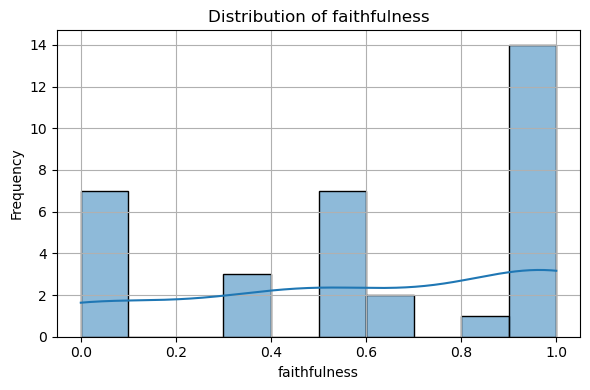

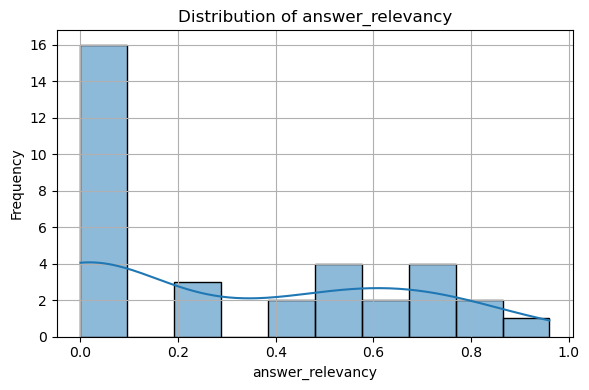

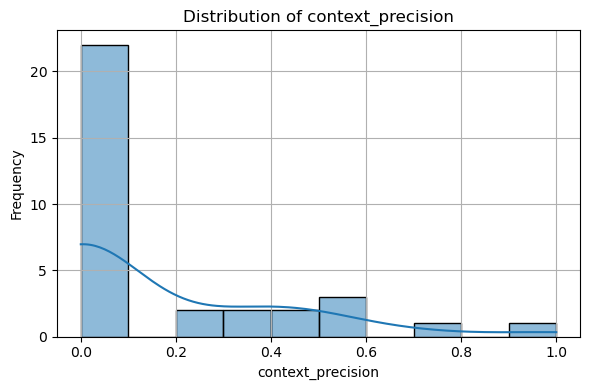

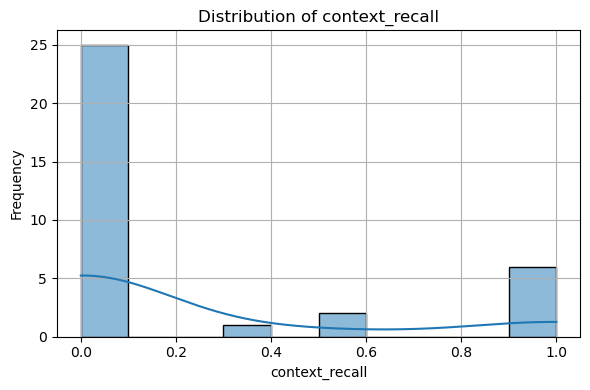

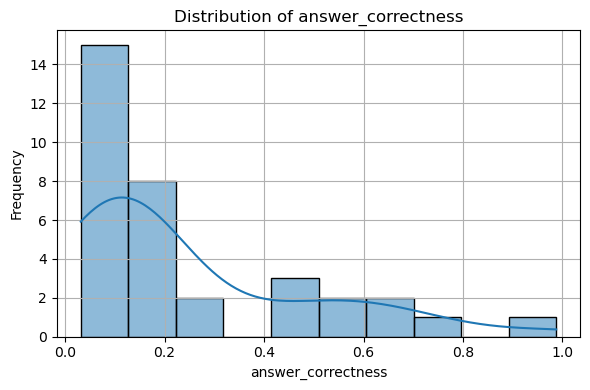

In [ ]:
'''
This script plots distribution histograms for each RAGAS evaluation metric 
 
'''
import matplotlib.pyplot as plt
import seaborn as sns

metrics = ['faithfulness', 'answer_relevancy', 'context_precision', 'context_recall', 'answer_correctness']

for metric in metrics:
    plt.figure(figsize=(6, 4))
    sns.histplot(df[metric], bins=10, kde=True)
    plt.title(f'Distribution of {metric}')
    plt.xlabel(metric)
    plt.ylabel('Frequency')
    plt.grid(True)
    plt.tight_layout()
    plt.show()


In [ ]:
'''
This script Inspects the RAGAS evaluation results and calculates the avaerage for each metric

'''

csv_filename = "ragas_naive_results.csv" 
try:
    scores_df = pd.read_csv(csv_filename)
    print(f"Successfully loaded RAGAS scores from '{csv_filename}'")
    print(f"Number of evaluated questions: {len(scores_df)}")

    print("\n--- DataFrame Info ---")
    scores_df.info()

    print("\n--- RAGAS Scores (First 10 Rows) ---")
    
    pd.set_option('display.max_colwidth', None)
    pd.set_option('display.max_rows', 20) 
    print(scores_df.head(10).to_string())

    print("\n--- Aggregated RAGAS Scores (Averages) ---")
    metric_columns = [
        'faithfulness', 
        'answer_relevancy', 
        'context_precision', 
        'context_recall', 
        'answer_correctness',
        'semantic_similarity' 
    ]
    
    for metric_name in metric_columns:
        if metric_name in scores_df.columns:
          
            scores_df[metric_name] = pd.to_numeric(scores_df[metric_name], errors='coerce')
       
            mean_score = scores_df[metric_name].mean(skipna=True)
            if pd.notna(mean_score):
                print(f"Average {metric_name}: {mean_score:.4f}")
            else:
                print(f"Average {metric_name}: Not available (all values might be NaN or non-numeric after coercion).")
        else:
            print(f"Metric column '{metric_name}' not found in results DataFrame.")

except FileNotFoundError:
    print(f"ERROR: File '{csv_filename}' not found.")
except Exception as e:
    print(f"An error occurred: {e}")

Successfully loaded RAGAS scores from 'ragas_naive_results.csv'
Number of evaluated questions: 45

--- DataFrame Info ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45 entries, 0 to 44
Data columns (total 11 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   user_input           45 non-null     object 
 1   retrieved_contexts   45 non-null     object 
 2   response             45 non-null     object 
 3   reference            45 non-null     object 
 4   faithfulness         34 non-null     float64
 5   answer_relevancy     34 non-null     float64
 6   context_precision    33 non-null     float64
 7   context_recall       34 non-null     float64
 8   answer_correctness   34 non-null     float64
 9   semantic_similarity  45 non-null     float64
 10  question_id          45 non-null     object 
dtypes: float64(6), object(5)
memory usage: 4.0+ KB

--- RAGAS Scores (First 10 Rows) ---
                                   